In [26]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import secrets
import datetime
import tqdm

In [11]:
# Create an EV class with the following attributes:
# - Brand
# - Model
# - Battery type
# - Battery size
# - Charging Efficiency
# - Discharging Efficiency
# - Energy per km
# - SOC min
# - SOC max
# - Probability in population - this is the probability that a car of this type will be chosen from the population

class EV:
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population):
        self.brand = brand
        self.model = model
        self.battery_type = battery_type
        self.battery_size = battery_size
        self.charging_efficiency = charging_efficiency if charging_efficiency <= 1 or charging_efficiency >= 0 else 0.9
        self.discharging_efficiency = discharging_efficiency if discharging_efficiency <= 1 or discharging_efficiency >= 0 else 0.9
        self.energy_per_km = energy_per_km
        self.soc_min = soc_min if soc_min >= 0.0 else 0.0
        self.soc_max = soc_max if soc_max <= 1.0 else 1.0
        self.probability_in_population = probability_in_population if probability_in_population <= 1.0 else 1.0


# Extend the class to create drivable EVs
class DrivableEV(EV):

    # __init__ method is inherited from EV class, extended with the state of charge. Creates the following attributes:
    # - State of Charge
    # - List of trips
    # - Current trip
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, initial_soc=None, stopping_soc=None):
        super().__init__(brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population)

        # EV ID
        self.ev_id = secrets.token_hex(16)

        # SOC variables
        self.soc = [initial_soc]
        self.current_soc = initial_soc
        # Attribute a random SOC to stop the EV if none is provided
        self.stopping_soc = stopping_soc if stopping_soc is not None else np.random.uniform(0.2, 0.3, 1)[0]

        # List of trips and current trip
        self.trips = []
        self.split_trips = []

        # Placeholder for the charging station pools that the EV will use
        self.default_charging_stations_pool = None
        self.segment_charging_stations_pool = None

        # Placeholder for the charging station that the EV will use
        self.default_charging_station = None
        self.segment_charging_station = None

        # Create a list of charging stations
        self.charging_stations_list = []

        # Number of stops
        self.number_of_stops = 0

        # Charging times
        self.charging_start_time = []
        self.charging_end_time = []
        self.charging_type = []
        self.charging_power = []
        self.charging_start_soc = []
        self.charging_end_soc = []


    # Format the print
    def __repr__(self):
        return f"{self.brand} {self.model} with {self.battery_size} kWh battery"


    # Create a method to add a trip to the EV
    def add_trip(self, trip):
        self.trips.append(trip)


    # Create a method to charge the EV
    def charge(self, charge_amount):
        self.current_soc += charge_amount * self.charging_efficiency

        if self.current_soc > 1.0:
            self.current_soc = 1.0

        self.soc.append(self.current_soc)


    # Create a method to discharge the EV
    def discharge(self, discharge_amount):
        self.current_soc -= discharge_amount / self.discharging_efficiency

        if self.current_soc < 0:
            self.current_soc = 0

        self.soc.append(self.current_soc)


    # Create a method to assign the allowed charging stations by the profile
    def assign_charging_stations(self):

        # Check if charging stations were already assigned
        if len(self.charging_stations_list) > 0:
            return

        # Get the charging stations from the profile
        allowed_charging_stations = self.trips[0].profile.allowed_charging_stations

        # Default stations
        self.default_charging_stations_pool = allowed_charging_stations['Default']

        # Segment stations
        self.segment_charging_stations_pool = allowed_charging_stations['Segment']

        # Pick the default charging station
        self.default_charging_station = np.random.choice(self.default_charging_stations_pool, 1,
                                                         p=[x.charging_station_probability for x in self.default_charging_stations_pool])[0]
        self.default_charging_station.ev_id = self.ev_id

        # Pick the segment charging station
        self.segment_charging_station = np.random.choice(self.segment_charging_stations_pool, 1,
                                                         p=[x.charging_station_probability for x in self.segment_charging_stations_pool])[0]
        self.segment_charging_station.ev_id = self.ev_id

        # Create a list of charging stations
        self.charging_stations_list = [self.default_charging_station, self.segment_charging_station]


    # Create a method to split the assigned trips in which the EV SOC is not enough to cover it
    def split_ev_trips(self):
        list_split_trips = []

        # Create new DrivableTrip object based on assigned trips and append to the list:
        # - Check if trip required energy is more than the EV SOC
        # - If yes, segment the trip and calculate the covered trip length, the remaining trip length and the energy required for each until the EV SOC is enough to cover the remaining trip
        # - If no, append the trip to the list
        for i in range(len(self.trips)):
            trip = self.trips[i]

            # Check if assigned profile allows charging during the day
            charge_during_day = trip.profile.charge_during_day

            # Check need to split trip
            if trip.trip_required_soc > (self.current_soc - self.stopping_soc):
                # Initialize the covered trip length and remaining trip length
                covered_trip_length = 0
                remaining_trip_length = trip.trip_length

                # Current time for trip start
                current_time = trip.trip_start_time

                # Initialize the energy required for the trip
                energy_required = trip.trip_required_soc

                # Loop to segment the trip until the EV SOC is enough to cover the remaining trip
                while energy_required > (self.current_soc - self.stopping_soc):

                    # Calculate used energy
                    used_energy = (self.current_soc - self.stopping_soc)

                    # Calculate the covered trip length of the current segment
                    current_covered_trip_length = (self.battery_size * used_energy)  / self.energy_per_km

                    # Check for end of trip
                    if current_covered_trip_length >= remaining_trip_length:
                        current_covered_trip_length = remaining_trip_length
                        used_energy = (current_covered_trip_length * self.energy_per_km) / self.battery_size

                    # Calculate the covered trip length
                    covered_trip_length += current_covered_trip_length
                    remaining_trip_length -= current_covered_trip_length
                    energy_required -= used_energy
                    self.discharge(used_energy)

                    # Calculate duration of covered distance as datetime
                    covered_trip_duration = current_covered_trip_length / trip.trip_speed
                    covered_trip_duration = datetime.timedelta(hours=covered_trip_duration)

                    # Segment end time
                    trip_end_time = current_time + covered_trip_duration

                    # Create a new DrivableTrip object with segment information and append to the list
                    drivable_trip = DrivableTrip(current_covered_trip_length, trip.trip_speed,
                                                 current_time, trip_end_time, covered_trip_duration,
                                                 profile=trip.profile,
                                                 trip_id=trip.trip_id)

                    # Add the EV information to the trip
                    drivable_trip.ev = self
                    drivable_trip.ev_id = self.ev_id
                    drivable_trip.calculate_trip_energy_consumption()
                    drivable_trip.calculate_trip_required_soc()
                    drivable_trip.assign_ev_battery_size()

                    list_split_trips.append(drivable_trip)

                    # Update the number of stops
                    self.number_of_stops += 1

                    # Determine the time to charge the EV
                    charge_time = (self.battery_size * 0.8 - self.current_soc * self.battery_size) / self.segment_charging_station.charging_station_power * self.segment_charging_station.charging_station_efficiency

                    # Calculate the charge time as datetime
                    charge_time = datetime.timedelta(hours=charge_time)

                    # Calculate the end time of the charge
                    charge_end_time = trip_end_time + charge_time

                    # Update the current time
                    current_time = charge_end_time

                    # Check if there is a next trip
                    if i < len(self.trips) - 1:
                        # Check if the next trip starts before the end of the charge
                        if self.trips[i + 1].trip_start_time < charge_end_time:
                            # Calculate the time to charge the EV
                            charge_time = (self.trips[i + 1].trip_start_time - trip_end_time).total_seconds() / 3600
                            charge_time = datetime.timedelta(hours=charge_time)

                            # Calculate the end time of the charge
                            charge_end_time = trip_end_time + charge_time

                    # Save the current SOC
                    current_soc = self.current_soc

                    # Power to charge the EV (SOC)
                    to_charge_soc = 0.8 - self.current_soc

                    # Charge the EV until it reaches 0.8 of the battery size or the end of the charge
                    if current_time < charge_end_time:
                        # Calculate the charge amount
                        to_charge_soc = (charge_end_time - current_time).total_seconds() / 3600 * self.segment_charging_station.charging_station_power / self.segment_charging_station.charging_station_efficiency / self.battery_size

                    self.charge(to_charge_soc)

                    # Update time
                    current_time = charge_end_time

                    # Update the charging station history
                    #self.segment_charging_station.update_history(trip_end_time, charge_end_time)

                    # Update the charging station history
                    self.charging_start_time.append(trip_end_time)
                    self.charging_end_time.append(charge_end_time)
                    self.charging_type.append(self.segment_charging_station.charging_station_type)
                    self.charging_power.append(self.segment_charging_station.charging_station_power)
                    self.charging_start_soc.append(current_soc)
                    self.charging_end_soc.append(self.current_soc)


                # Discharge the remaining energy
                self.discharge(energy_required)

                # Update current time
                current_time += datetime.timedelta(hours=remaining_trip_length / trip.trip_speed)

                # Check if profile allows charging at end
                #if charge_during_day or i == len(self.trips) - 1:

                    # Charge the EV at the end of trip to 0.8 of the battery size if needed
                    #if self.current_soc < 1.0:
                        # Update the time to charge the EV using the default charging station
                        #charge_time = (self.battery_size * 1.0 - self.current_soc * self.battery_size) / self.default_charging_station.charging_station_power * self.default_charging_station.charging_station_efficiency
                        #charge_time = datetime.timedelta(hours=charge_time)

                        # Save the current SOC
                        #current_soc = self.current_soc

                        #self.charge(1.0 - current_soc)

                        # Update the charging station history
                        #self.charging_start_time.append(current_time)
                        #self.charging_end_time.append(current_time + charge_time)
                        #self.charging_type.append(self.default_charging_station.charging_station_type)
                        #self.charging_power.append(self.default_charging_station.charging_station_power)
                        #self.charging_start_soc.append(current_soc)
                        #self.charging_end_soc.append(self.current_soc)

            else:
                # Simply add the trip to the list
                list_split_trips.append(trip)

                # Discharge the required SOC
                self.discharge(trip.trip_required_soc)

                # Update the current time
                current_time = trip.trip_end_time

            # Charge if profile allows
            if charge_during_day or i == len(self.trips) - 1:

                # Charge the EV at the end of trip to 0.8 of the battery size if needed
                if self.current_soc < 0.8:
                    # Update the time to charge the EV using the default charging station
                    charge_time = (self.battery_size - self.current_soc * self.battery_size) / self.default_charging_station.charging_station_power * self.default_charging_station.charging_station_efficiency
                    charge_time = datetime.timedelta(hours=charge_time)

                    # Save the current SOC
                    current_soc = self.current_soc

                    # Save the current SOC to charge
                    to_charge_soc = 0.8 - self.current_soc

                    # Check if there is a next trip
                    if i < len(self.trips) - 1:
                        # Check if the next trip starts before the end of the charge
                        if self.trips[i + 1].trip_start_time < current_time + charge_time:
                            # Calculate the time to charge the EV
                            charge_time = (self.trips[i + 1].trip_start_time - current_time).total_seconds() / 3600

                            # Calculate the charge amount
                            to_charge_soc = charge_time * self.default_charging_station.charging_station_power * self.default_charging_station.charging_station_efficiency / self.battery_size

                            # Convert the charge time to datetime
                            charge_time = datetime.timedelta(hours=charge_time)

                    self.charge(to_charge_soc)

                    # Update the charging station history
                    self.charging_start_time.append(trip.trip_end_time)
                    self.charging_end_time.append(trip.trip_end_time + charge_time)
                    self.charging_type.append(self.default_charging_station.charging_station_type)
                    self.charging_power.append(self.default_charging_station.charging_station_power)
                    self.charging_start_soc.append(current_soc)
                    self.charging_end_soc.append(self.current_soc)


        # Update the trips list
        self.split_trips = list_split_trips


    # Reset the EV to the initial state except the SoC
    # If the EV carries charging over days, keep the information
    def reset(self):

        # Reset the current time
        self.trips = []
        self.split_trips = []

        # Check if there was charging
        if len(self.charging_end_time) == 0:
            return

        temp_charge_start_time = None
        temp_charge_end_time = None
        # Keep charging if the EV carries charging over days
        if self.charging_end_time[-1].day > self.charging_start_time[-1].day:

            # Keep the charging information relative to the remaining charge
            temp_charge_start_time = datetime.datetime(self.charging_end_time[-1].year,
                                                       self.charging_end_time[-1].month,
                                                       self.charging_end_time[-1].day,
                                                       0, 0, 0)

            temp_charge_end_time = self.charging_end_time[-1]

            # Update the charging information
            self.number_of_stops = 1
            self.charging_start_time = [temp_charge_start_time]
            self.charging_end_time = [temp_charge_end_time]
            self.charging_type = [self.charging_type[-1]]
            self.charging_power = [self.charging_power[-1]]
            self.charging_start_soc = [self.charging_start_soc[-1]]
            self.charging_end_soc = [self.charging_end_soc[-1]]

        else:
            # Reset the charging station history
            self.number_of_stops = 0
            self.charging_start_time = []
            self.charging_end_time = []
            self.charging_type = []
            self.charging_power = []
            self.charging_start_soc = []
            self.charging_end_soc = []


In [3]:
# Define a Trip class, that will assign a trip to an EV. Has the following parameters:
# - EV
# - Trip length
# - Trip start time (can be a range)
# - Trip end time (can be a range)
# - Trip start SOC
# - Trip end SOC
# - Trip energy consumption
# - Trip stops

class Trip:
    def __init__(self, trip_length, trip_start_time, trip_end_time, trip_duration):
        self.trip_length = trip_length
        self.trip_start_time = trip_start_time
        self.trip_end_time = trip_end_time
        self.trip_duration = trip_duration


class DrivableTrip(Trip):
    # Init method is the same as Trip class
    def __init__(self, trip_length, trip_speed, trip_start_time, trip_end_time, trip_duration, profile=None, trip_id=None):
        super().__init__(trip_length, trip_start_time, trip_end_time, trip_duration)

        # Information about EV
        self.ev = None
        self.ev_id = None

        # Information about the trip
        self.trip_speed = trip_speed
        self.trip_energy_consumption = None
        self.trip_required_soc = None
        self.covered_trip_length = None
        self.ev_battery_size = None
        self.trip_estimate_arrival = trip_end_time
        self.profile = profile

        # Assign a trip ID
        self.trip_id = trip_id if trip_id is not None else secrets.token_hex(16)


    # Formatted print method
    def __repr__(self):
        return f'Trip length: {self.trip_length} km, trip start time: {self.trip_start_time}, ' \
               f'trip end time: {self.trip_end_time}, trip energy consumption: {self.trip_energy_consumption} kWh, ' \
               f'trip required SOC: {self.trip_required_soc} %'

    # Create a method to calculate the trip energy consumption
    def calculate_trip_energy_consumption(self):
        self.trip_energy_consumption = self.trip_length * self.ev.energy_per_km


    # Create a method to calculate the trip required SOC
    def calculate_trip_required_soc(self):
        self.trip_required_soc = self.trip_energy_consumption / self.ev.battery_size


    # Create a method to assign the battery size of the EV to the trip
    def assign_ev_battery_size(self):
        self.ev_battery_size = self.ev.battery_size


    # Create a method to update the covered trip length
    def update_covered_trip_length(self, covered_trip_length):
        self.covered_trip_length += covered_trip_length


    # Create a method to update the required SOC
    def update_trip_required_soc(self):
        self.trip_required_soc = (self.trip_energy_consumption - self.covered_trip_length * self.ev.energy_per_km) / self.ev.battery_size


In [4]:
# Define a Charging Station class, that will charge the EVs. Has the following parameters:
# - Charging station name
# - Charging station location
# - Charging station type
# - Charging station power
# - Charging station efficiency
# - Charging station availability
# - Charging station cost

class ChargingStation:
    def __init__(self, charging_station_type, charging_station_power, charging_station_efficiency, charging_station_cost,
                 charging_station_probability, ev_id=None):
        # Parameters Assign
        self.charging_station_type = charging_station_type
        self.charging_station_power = charging_station_power
        self.charging_station_cost = charging_station_cost
        self.charging_station_efficiency = charging_station_efficiency
        self.charging_station_probability = charging_station_probability

        # Charging station history
        self.charging_station_history = []

        # EV ID
        self.ev_id = ev_id


    # Formatted print method
    def __repr__(self):
        return f'Charging station type: {self.charging_station_type}, charging station power: {self.charging_station_power}'


In [5]:
# Define a User class, that will have the following parameters:
# - User name
# - User location
# - User trips
# - User EV
# - User type

class User:
    def __init__(self, user_name, user_profile):
        # Parameters Assign
        self.user_name = user_name
        self.user_profile = user_profile

    # Method to assign an EV to the user
    def assign_ev(self, ev):
        self.user_ev = ev


# Create a Profile class that will determine the behaviour of the Users. Has the following parameters:
# - Profile name
# - Profile type
# - Profile trip schedule
# - Trip type
class Profile:
    def __init__(self, profile_name, trip_type, profile_trip_schedule, allowed_charging_stations, charge_during_day=True):
        # Parameters Assign
        self.profile_name = profile_name
        self.trip_type = trip_type
        self.profile_trip_schedule = profile_trip_schedule
        self.allowed_charging_stations = allowed_charging_stations
        self.charge_during_day = charge_during_day

    # Format printing
    def __repr__(self):
        return f'N:{self.profile_name}, T:{self.trip_type}'


# Create a Schedule class with the following parameters:
# - Schedule start
# - Schedule end
class Schedule:
    def __init__(self, schedule_start):
        # Parameters Assign
        self.schedule_start = schedule_start

    # Format printing
    def __repr__(self):
        return f'Schedule start hours: {self.schedule_start}'

In [39]:
 # Define an Aggregator class, that will aggregate the trips and EVs. Has the following parameters:
# - EVs
# - Number of EVs
class Aggregator:
    def __init__(self, profiles, evs,
                 n_evs=1, time_resolution=1,
                 avg_speed_short=60, avg_speed_medium=80, avg_speed_long=100,
                 medium_trip_min=50, medium_trip_max=100, trip_start_variation=1.0, avg_speed_variation=1.0,
                 simulation_cycles=1):
        # Profile assign
        self.profiles = profiles

        # Temporal resolution
        self.time_resolution = time_resolution

        # Simulation cycle definition
        self.simulation_cycles = simulation_cycles

        # Assign the EVs to the aggregator
        self.evs = evs

        # Number of EVs of the simulation
        self.number_of_evs = n_evs

        # Create a list of trips
        self.trips = []
        self.segments = []
        self.population = None
        self.assigned_evs = []

        # Trip creation parameters
        self.avg_speed_short = avg_speed_short
        self.avg_speed_medium = avg_speed_medium
        self.avg_speed_long = avg_speed_long
        self.medium_trip_min = medium_trip_min
        self.medium_trip_max = medium_trip_max
        self.trip_start_variation = trip_start_variation
        self.avg_speed_variation = avg_speed_variation

        # Placeholder for simulation results
        self.simulation_variables = {}
        self.simulation_dataframes = {}
        self.simulation_step = 0

    # Add an EV to the fleet
    def add_ev(self, ev):
        self.evs.append(ev)

    # Assign a trip to an EV
    def assign_trip(self, ev, trip):
        ev.add_trip(trip)

    # Assign a charging station to an EV, and charge the EV if:
    # - The charging station is available
    # - The charging station is of the correct type
    # - The charging station has enough power to charge the EV
    def assign_charging_station(self, ev, charging_station):
        if charging_station.charging_station_availability == True and charging_station.charging_station_type == ev.battery_type and charging_station.charging_station_power >= ev.battery_size:
            ev.current_charging_station = charging_station
            ev.charge(charging_station.charging_station_power)
            charging_station.charging_station_availability = False


    # Create the population of DrivableEVs according to NumPy's random.choice
    def create_evs(self, n_evs):
        # Assign the number of EVs to the aggregator
        self.number_of_evs = n_evs

        # Print the progress
        print('Creating EVs...')
        # Create an EV population according to the given probabilities of the EVs
        population_choice = np.random.choice(self.evs, n_evs,
                                             p=[ev.probability_in_population for ev in self.evs])

        # Create a list of DrivableEVs
        self.population = [DrivableEV(ev.brand, ev.model, ev.battery_type, ev.battery_size,
                                      ev.charging_efficiency, ev.discharging_efficiency,
                                      ev.energy_per_km, ev.soc_min, ev.soc_max,
                                      ev.probability_in_population,
                                      initial_soc=np.round(np.random.uniform(ev.soc_min,
                                                                             ev.soc_max, 1)[0], 2))
                           for ev in tqdm.tqdm(population_choice)]


    # Create DrivableTrips with gamma distribution for the trip length
    # Create a gamma distribution for the trip length
    def create_trips(self):
        shape, scale = 46.*.01, 46.*2
        trip_lengths = np.round(np.random.gamma(shape, scale, self.number_of_evs), 2)

        # Assign the trip lengths to the trips list
        self.trips = [Trip(trip_length, None, None, None) for trip_length in trip_lengths]

        # Create the DrivableTrips
        for trip in range(self.number_of_evs):

            # Calculate trip type based on distance
            trip_type = 'Short' if trip_lengths[trip] <= self.medium_trip_min else 'Medium' if self.medium_trip_min < trip_lengths[trip] <= self.medium_trip_max else 'Long'

            # Calculate average speed based on trip type
            avg_speed = self.avg_speed_short if trip_type == 'Short' else self.avg_speed_medium if trip_type == 'Medium' else self.avg_speed_long

            # Get the user profiles that match the trip type
            user_profiles = [profile for profile in self.profiles if profile.trip_type == trip_type]

            # Get the user profile based on the user profiles that match the trip type
            user_profile = np.random.choice(user_profiles, 1)[0]

            # Check how many trips the user has
            user_trips = len(user_profile.profile_trip_schedule.schedule_start)

            # If there are more than 1 trip, split into multiple trips
            if user_trips > 1:

                # Placeholder for list of segments of each trip. Each segment is a DrivableTrip
                segment_list = []

                # Calculate the required socs for trip segment
                for i in range(user_trips):
                    # Get a random start centered around schedule start
                    segment_start = np.random.uniform(user_profile.profile_trip_schedule.schedule_start[i] - self.trip_start_variation,
                                                      user_profile.profile_trip_schedule.schedule_start[i] + self.trip_start_variation, 1)[0]

                    # Get a random average speed centered on avg_speed with variation
                    segment_avg_speed = np.random.uniform(avg_speed - self.avg_speed_variation, avg_speed + self.avg_speed_variation, 1)[0] * self.time_resolution

                    # Calculate the segment end
                    segment_end = segment_start + trip_lengths[trip] / segment_avg_speed

                    # Calculate the segment length
                    duration = segment_end - segment_start if segment_end > segment_start else 0

                    # Convert float values to timestamp
                    segment_start = datetime.datetime(2023, 1, self.simulation_step+1, int(segment_start), int((segment_start - int(segment_start)) * 60))
                    segment_end = datetime.datetime(2023, 1, self.simulation_step+1, int(segment_end)%24, int((segment_end - int(segment_end)) * 60))
                    #duration = datetime.datetime(2023, 1, 1, int(duration), int((duration - int(duration)) * 60))
                    duration = datetime.timedelta(hours=duration)

                    # Create a DrivableTrip for each segment
                    segment_list.append(DrivableTrip(trip_lengths[trip] / user_trips,
                                                     segment_avg_speed,
                                                     segment_start, segment_end,
                                                     duration, profile=user_profile))

                # Append to the trips list
                self.segments.append(segment_list)

            elif user_trips == 1:

                # Get a random start centered around schedule start
                segment_start = np.random.uniform(user_profile.profile_trip_schedule.schedule_start[0] - self.trip_start_variation,
                                                  user_profile.profile_trip_schedule.schedule_start[0] + self.trip_start_variation, 1)[0]

                # Get a random average speed centered on avg_speed with variation
                segment_avg_speed = np.random.uniform(avg_speed - self.avg_speed_variation, avg_speed + self.avg_speed_variation, 1)[0] * self.time_resolution

                # Calculate the segment end
                segment_end = segment_start + trip_lengths[trip] / segment_avg_speed

                # Calculate the segment length
                duration = segment_end - segment_start if segment_end > segment_start else 0

                # Convert float values to time
                segment_start = datetime.datetime(2023, 1, 1, int(segment_start), int((segment_start - int(segment_start)) * 60))
                segment_end = datetime.datetime(2023, 1, 1, int(segment_end), int((segment_end - int(segment_end)) * 60))
                #duration = datetime.datetime(2023, 1, 1, int(duration), int((duration - int(duration)) * 60))
                duration = datetime.timedelta(hours=duration)

                # Create a DrivableTrip for the trip
                drivable_trip = DrivableTrip(trip_lengths[trip],
                                             segment_avg_speed,
                                             segment_start, segment_end,
                                             duration, profile=user_profile)

                # Append to the segments list
                self.segments.append([drivable_trip])


    # Assign the larger trips to the EVs with larger battery sizes with a greater probability
    def assign_trips(self):
        # Create a copy of the population
        population_copy = copy.deepcopy(self.population)
        segments_copy = copy.deepcopy(self.segments)

        # Assigned EVs and Trips
        assigned_evs = []

        # Create a list with the probabilities of the EVs to get a trip
        probabilities = [ev.battery_size / sum([ev.battery_size for ev in self.population]) for ev in population_copy]

        # Sort the segments by trip length and assign it to a temporary variable
        sorted_segments = sorted(segments_copy, key=lambda x: x[0].trip_length, reverse=True)

        # Print progress
        print('Assigning trips to EVs...')

        # Assign the sorted trips to the EVs
        for segment in tqdm.tqdm(sorted_segments):
            # Choose an EV from the population
            ev = np.random.choice(population_copy, 1, p=probabilities)[0]

            for trip in segment:
                # Assign the trip segments to the EV
                trip.ev = ev
                trip.ev_id = ev.ev_id
                trip.calculate_trip_energy_consumption()
                trip.calculate_trip_required_soc()
                trip.assign_ev_battery_size()

                # Add the trip to the EV
                ev.add_trip(trip)
                ev.assign_charging_stations()

                # Calculate the trip energy consumption and required SOC
                trip.calculate_trip_energy_consumption()
                trip.calculate_trip_required_soc()

            # Split the trip into segments
            ev.split_ev_trips()

            # Remove the EV from the population
            population_copy.remove(ev)

            self.assigned_evs.append(ev)

            # Recalculate the probabilities
            probabilities = [ev.battery_size / sum([ev.battery_size for ev in population_copy]) for ev in population_copy]

            # If the population is empty, break the loop
            if len(population_copy) == 0:
                break


    # Reset the EVs
    def reset_cycle(self):

        # Reset the EVs
        self.population = copy.deepcopy(self.assigned_evs)
        self.trips = []
        self.segments = []

        for ev in self.population:
            ev.reset()


    # Get the simulation results
    def get_simulation_results(self):
        # Increment the simulation number
        self.simulation_step += 1

        # Create a deep copy of all class variables the Aggregator instance
        simulation_results = copy.deepcopy(self.__dict__)
        # Add to the results
        self.simulation_variables['gen{:003d}'.format(self.simulation_step)] = simulation_results

        # Create a deep copy of the Dataframes generated by the simulation
        dataframes = self.get_dataframes()
        # Add the Dataframes to the simulation results
        self.simulation_dataframes['gen{:003d}'.format(self.simulation_step)] = dataframes


    # Establish a simulation loop based on the number of days specified
    def run_simulation(self):

        # If the simulation's number of days is less than 1, set to 1 and run the first day
        if self.simulation_cycles < 1:
            print('Simulation days must be greater than 0. Setting to 1.')
            self.simulation_cycles = 1

        # Run the simulation for the first day

        # Print the simulation progress
        print('Simulating cycle {:003d} of {:003d}...'.format(self.simulation_step + 1, self.simulation_cycles))

        self.create_evs(self.number_of_evs)
        self.create_trips()
        self.assign_trips()
        self.get_simulation_results()

        # Run the simulation for the remaining days
        for day in range(1, self.simulation_cycles):

            print('Simulating cycle {:003d} of {:003d}...'.format(self.simulation_step + 1, self.simulation_cycles))

            # Reset the cycle
            self.reset_cycle()

            # Create the trips
            self.create_trips()

            # Assign the trips to the EVs
            self.assign_trips()

            # Get the simulation results
            self.get_simulation_results()


    # Create a DataFrame of the population
    def population_dataframe(self):
        # Create a DataFrame of the population
        population_dataframe = pd.DataFrame([ev.__dict__ for ev in self.population])

        # Return the DataFrame
        return population_dataframe


    # Create a DataFrame of assigned EVs
    def assigned_evs_dataframe(self):
        # Create a DataFrame of the population
        assigned_evs_dataframe = pd.DataFrame([ev.__dict__ for ev in self.assigned_evs])

        # Return the DataFrame
        return assigned_evs_dataframe


    # Create a DataFrame of the trips
    def assigned_trips_dataframe(self):
        # Create a DataFrame of the trips
        trips_dataframe = pd.DataFrame([trip.trip_length for trip in self.trips])
        trips_dataframe.columns = ["trip_length"]

        # Return the DataFrame
        return trips_dataframe


    # Create a DataFrame of assigned Trips and all the information in the list
    def assigned_segments_dataframe(self):
        # Create a DataFrame of the population
        assigned_trips_dataframe = pd.DataFrame([trip.__dict__ for ev in self.assigned_evs for trip in ev.trips])

        # Return the DataFrame
        return assigned_trips_dataframe


    # Create a DataFrame of the EVs' split trips
    def assigned_split_trips_dataframe(self):
        # Create a DataFrame of the population
        assigned_split_trips_dataframe = pd.DataFrame([trip.__dict__ for ev in self.assigned_evs for trip in ev.split_trips])

        # Return the DataFrame
        return assigned_split_trips_dataframe


    # Create a DataFrame of the charging stations used by the EVs
    def assigned_cs_dataframe(self):
        # Create a DataFrame of the population
        assigned_cs_dataframe = pd.DataFrame([cs.__dict__ for ev in self.assigned_evs for cs in ev.charging_stations_list])

        # Return the DataFrame
        return assigned_cs_dataframe


    # Create a DataFrame with history information of the CS
    def assigned_cs_history_dataframe(self):

        # Create a list for start and end times, EV ID
        start_times = []
        end_times = []
        ev_ids = []

        # Iterate through the EVs
        for ev in self.assigned_evs:
            # Iterate through the charging stations
            for cs in ev.charging_stations_list:
                # Iterate through the charging sessions
                for i in range(len(cs.charging_station_history)):
                    # Append the start and end times
                    start_times.append(cs.charging_station_history[i][0])
                    end_times.append(cs.charging_station_history[i][1])
                    ev_ids.append(ev.ev_id)

        # Create a DataFrame
        cs_history_dataframe = pd.DataFrame({"start_time": start_times, "end_time": end_times, "ev_id": ev_ids})

        # Return the DataFrame
        return cs_history_dataframe


    # Create a DataFrame composed by:
    # EV charging start time, EV charging end time, EV charging start soc, EV charging end soc, EV ID
    def cs_charging_dataframe(self):

        # Create placeholder lists
        start_times = []
        end_times = []

        station_type = []
        station_power = []

        start_socs = []
        end_socs = []

        ev_ids = []

        # Iterate through the EVs
        for ev in self.assigned_evs:

            # Check if there were any events
            if len(ev.charging_start_time) == 0:
                continue

            # Iterate through the events
            for i in range(len(ev.charging_start_time)):
                start_times.append(ev.charging_start_time[i])
                end_times.append(ev.charging_end_time[i])

                station_type.append(ev.charging_type[i])
                station_power.append(ev.charging_power[i])

                start_socs.append(ev.charging_start_soc[i])
                end_socs.append(ev.charging_end_soc[i])

                ev_ids.append(ev.ev_id)

        # Create the DataFrame
        charging_dataframe = pd.DataFrame({"start_time": start_times, "end_time": end_times, "start_soc": start_socs,
                                           "end_soc": end_socs, "ev_id": ev_ids, "station_type": station_type, "station_power": station_power})

        # Return the DataFrame
        return charging_dataframe


    # Create a DataFrame of EV charging history
    def ev_charging_history_dataframe(self):

        # Get a DataFrame of EV charging history
        ev_charging_history = self.cs_charging_dataframe()

        # Remove rows with start_time equals to end_time
        ev_charging_history = ev_charging_history[ev_charging_history['start_time'] != ev_charging_history['end_time']]

        # Remove duplicates
        ev_charging_history = ev_charging_history.drop_duplicates()

        # Add column with the duration of the charging session
        ev_charging_history['duration'] = ev_charging_history['end_time'] - ev_charging_history['start_time']

        # Add column with start hour
        ev_charging_history['start_hour'] = ev_charging_history['start_time'].dt.hour

        # Add column with end hour
        ev_charging_history['end_hour'] = ev_charging_history['end_time'].dt.hour

        # Return the DataFrame
        return ev_charging_history


    # Create a DataFrame with the EV IDs as index and hour range as columns to indicate the charging sessions
    def ev_charging_history_hourly_dataframe(self):

        # Get a DataFrame of EV charging history
        ev_charging_history = self.ev_charging_history_dataframe()

        # Create a DataFrame with the EV IDs as index
        ev_charging_history_hourly = pd.DataFrame(index=ev_charging_history['ev_id'].unique())

        # Create a list of hours
        hours = list(range(0, 24))

        # Create a column for each hour
        for hour in hours:
            ev_charging_history_hourly['{:02d}'.format(hour)] = 0


        # Fill the DataFrame with the charging sessions
        for index, row in ev_charging_history.iterrows():
            for hour in range(row['start_hour'], row['end_hour'] + 1):
                ev_charging_history_hourly.loc[row['ev_id'], '{:02d}'.format(hour)] += 1

        # Return the DataFrame
        return ev_charging_history_hourly


    # Create a DataFrame with the EV IDs as index and hour range as columns to indicate the charging session station power
    def ev_charging_history_hourly_power_dataframe(self):

        # Get a DataFrame of EV charging history
        ev_charging_history = self.ev_charging_history_dataframe()

        # Create a DataFrame with the EV IDs as index
        ev_charging_history_power_hourly = pd.DataFrame(index=ev_charging_history['ev_id'].unique())

        # Create a list of hours
        hours = list(range(0, 24))

        # Create a column for each hour
        for hour in hours:
            ev_charging_history_power_hourly['{:02d}'.format(hour)] = 0

        # Fill the DataFrame with the charging sessions
        for index, row in ev_charging_history.iterrows():
            for hour in range(row['start_hour'], row['end_hour'] + 1):
                fraction = 0
                # Check the fraction of the hour that the EV is charging
                if hour == row['start_hour']:
                    fraction = 1 - (row['start_time'].minute / 60)
                elif hour == row['end_hour']:
                    fraction = row['end_time'].minute / 60
                else:
                    fraction = 1
                ev_charging_history_power_hourly.loc[row['ev_id'], '{:02d}'.format(hour)] += row['station_power'] * fraction

        # Round the DataFrame
        ev_charging_history_power_hourly = ev_charging_history_power_hourly.round(2)

        # Return the DataFrame
        return ev_charging_history_power_hourly


    # Get an identical DataFrame to ev_charging_history_power_hourly but with the charging type
    def ev_charging_history_hourly_type_dataframe(self):

        # Get a DataFrame of EV charging history
        ev_charging_history = self.ev_charging_history_dataframe()

        # Create a DataFrame with the EV IDs as index
        ev_charging_history_type_hourly = pd.DataFrame(index=ev_charging_history['ev_id'].unique())

        # Create a list of hours
        hours = list(range(0, 24))

        # Create a column for each hour
        for hour in hours:
            ev_charging_history_type_hourly['{:02d}'.format(hour)] = 0

        # Fill the DataFrame with the charging sessions
        for index, row in ev_charging_history.iterrows():
            for hour in range(row['start_hour'], row['end_hour'] + 1):
                ev_charging_history_type_hourly.loc[row['ev_id'], '{:02d}'.format(hour)] = row['station_type']

        # Return the DataFrame
        return ev_charging_history_type_hourly


    # Get all the DataFrames for storage
    def get_dataframes(self):

        # Population DataFrame
        population_dataframe = self.population_dataframe()

        # Assigned EVs DataFrame
        assigned_evs_dataframe = self.assigned_evs_dataframe()

        # Assigned Trips
        assigned_trips_dataframe = self.assigned_trips_dataframe()

        # Assigned Segments
        assigned_segments_dataframe = self.assigned_segments_dataframe()

        # Assigned Split Trips
        assigned_split_trips_dataframe = self.assigned_split_trips_dataframe()

        # Assigned Charging Stations
        assigned_charging_stations_dataframe = self.assigned_cs_dataframe()


        # Get the DataFrames
        cs_history_dataframe = self.cs_charging_dataframe()
        ev_charging_history_dataframe = self.ev_charging_history_dataframe()
        ev_charging_history_hourly_dataframe = self.ev_charging_history_hourly_dataframe()
        ev_charging_history_hourly_power_dataframe = self.ev_charging_history_hourly_power_dataframe()
        ev_charging_history_hourly_type_dataframe = self.ev_charging_history_hourly_type_dataframe()

        # Place everything in a dictionary
        dataframes = {"population": population_dataframe, "assigned_evs": assigned_evs_dataframe,
                      "assigned_trips": assigned_trips_dataframe, "assigned_segments": assigned_segments_dataframe,
                      "assigned_split_trips": assigned_split_trips_dataframe, "assigned_charging_stations": assigned_charging_stations_dataframe,
                      "cs_history": cs_history_dataframe, "ev_charging_history": ev_charging_history_dataframe,
                      "ev_charging_history_hourly": ev_charging_history_hourly_dataframe,
                      "ev_charging_history_hourly_power": ev_charging_history_hourly_power_dataframe,
                      "ev_charging_history_hourly_type": ev_charging_history_hourly_type_dataframe}

        # Return the DataFrames
        return dataframes

In [40]:
# Create a list of EVs to use in the simulation

EVs = [EV(brand='Nissan', model='Leaf', battery_type='BEV', battery_size=59,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.16, energy_per_km=0.17, soc_min=0.7, soc_max=1.0),
       EV(brand='Tesla', model='Model 3', battery_type='BEV', battery_size=95,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.13, energy_per_km=0.18, soc_min=0.7, soc_max=1.0),
       EV(brand='Peugeot', model='e-Expert', battery_type='BEV', battery_size=68,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.26, soc_min=0.7, soc_max=1.0),
       EV(brand='Renault', model='Zoe', battery_type='BEV', battery_size=52,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.17, soc_min=0.7, soc_max=1.0),
       EV(brand='Jaguar', model='I-Pace', battery_type='BEV', battery_size=85,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.09, energy_per_km=0.22, soc_min=0.7, soc_max=1.0),
       EV(brand='Mercedes', model='E300', battery_type='PHEV', battery_size=13.5,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.18, soc_min=0.7, soc_max=1.0),
       EV(brand='BMW', model='530e', battery_type='PHEV', battery_size=70.2,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.16, soc_min=0.7, soc_max=1.0),
       EV(brand='Audi Q4', model='e-tron', battery_type='PHEV', battery_size=55,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.07, energy_per_km=0.17, soc_min=0.7, soc_max=1.0),
       EV(brand='Hyundai', model='Kauai', battery_type='BEV', battery_size=74,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.06, energy_per_km=0.192, soc_min=0.7, soc_max=1.0),
       EV(brand='Volvo', model='XC40', battery_type='PHEV', battery_size=78,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.176, soc_min=0.7, soc_max=1.0),
       EV(brand='Wolkswagen', model='ID.3', battery_type='PHEV', battery_size=58,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.155, soc_min=0.7, soc_max=1.0),
       EV(brand='Others', model='Others', battery_type='PEV', battery_size=20,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.03, energy_per_km=0.2, soc_min=0.7, soc_max=1.0)]

# Print the sum of the probabilities in the population of EVs
sum_of_probabilities = 0
for ev in EVs:
    sum_of_probabilities += ev.probability_in_population
print(sum_of_probabilities)

1.0


In [41]:
# Create a list of Charging Stations to use in the simulation

CS = [ChargingStation(charging_station_type='Slow',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Slow',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25)]


In [42]:
# Create a list of Charging Stations to use in the simulation

PUBLIC_STATIONS = [ChargingStation(charging_station_type='Public Ultrafast (150 kW)',
                                   charging_station_power=150,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.0233),
                   ChargingStation(charging_station_type='Public Fast (50 kW)',
                                   charging_station_power=50,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.434),
                   ChargingStation(charging_station_type='Public Semi-fast (22 kW)',
                                   charging_station_power=22,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.4394),
                   ChargingStation(charging_station_type='Public Slow (7.2 kW)',
                                   charging_station_power=7.2,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.1033)]

PRIVATE_STATIONS = [ChargingStation(charging_station_type='Private Fast (50 kW)',
                                    charging_station_power=50,
                                    charging_station_efficiency=0.9,
                                    charging_station_cost=0.297,
                                    charging_station_probability=0.0405),
                    ChargingStation(charging_station_type='Private Semi-fast (22 kW)',
                                    charging_station_power=22,
                                    charging_station_efficiency=0.9,
                                    charging_station_cost=0.297,
                                    charging_station_probability=0.9595)]

RESIDENTIAL_CS1 = [ChargingStation(charging_station_type='Residential Slow (3.6 kW)',
                                   charging_station_power=3.6,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.6),
                   ChargingStation(charging_station_type='Residential Slow (7.2 kW)',
                                   charging_station_power=7.2,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.4)]

RESIDENTIAL_CS2 = [ChargingStation(charging_station_type='Residential Slow (3.6 kW)',
                                   charging_station_power=3.6,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.3),
                   ChargingStation(charging_station_type='Residential Slow (7.2 kW)',
                                   charging_station_power=7.2,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.6),
                   ChargingStation(charging_station_type='Residential Semi-fast (22 kW)',
                                   charging_station_power=22,
                                   charging_station_efficiency=0.9,
                                   charging_station_cost=0.297,
                                   charging_station_probability=0.1)]


In [43]:
# Create the profiles to use in the simulation

# Create a list of profiles
PROFILES = [Profile(profile_name='Residential1', profile_trip_schedule=Schedule([8, 18]), trip_type='Short',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': RESIDENTIAL_CS1},
                    charge_during_day=False),
            Profile(profile_name='Residential2', profile_trip_schedule=Schedule([5, 18]), trip_type='Medium',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': RESIDENTIAL_CS1},
                    charge_during_day=False),
            Profile(profile_name='Residential3', profile_trip_schedule=Schedule([8, 19]), trip_type='Short',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': RESIDENTIAL_CS2},
                    charge_during_day=False),
            Profile(profile_name='Residential4', profile_trip_schedule=Schedule([8, 18]), trip_type='Long',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': RESIDENTIAL_CS2},
                    charge_during_day=False),
            Profile(profile_name='Work1', profile_trip_schedule=Schedule([8, 13, 19]), trip_type='Long',
                    allowed_charging_stations={'Segment': PUBLIC_STATIONS, 'Default': PRIVATE_STATIONS},
                    charge_during_day=True)]


In [44]:
# Create the simulation

aggregator = Aggregator(profiles=PROFILES, evs=EVs, n_evs=1000,
                        avg_speed_short=60, avg_speed_medium=80, avg_speed_long=100, avg_speed_variation=1.0,
                        simulation_cycles=7)

aggregator.run_simulation()

Simulating cycle 001 of 007...
Creating EVs...


100%|██████████| 1000/1000 [00:00<00:00, 55230.36it/s]

Assigning trips to EVs...

100%|█████████▉| 999/1000 [00:13<00:00, 74.76it/s] 


Simulating cycle 002 of 007...
Assigning trips to EVs...


100%|█████████▉| 999/1000 [00:13<00:00, 73.66it/s] 


Simulating cycle 003 of 007...
Assigning trips to EVs...


100%|██████████| 1000/1000 [01:56<00:00,  8.56it/s]


Simulating cycle 004 of 007...
Assigning trips to EVs...


 16%|█▌        | 162/1000 [01:12<06:13,  2.24it/s]


KeyboardInterrupt: 

In [162]:
# Print the population
aggregator.population_dataframe()

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,...,default_charging_station,segment_charging_station,charging_stations_list,number_of_stops,charging_start_time,charging_end_time,charging_type,charging_power,charging_start_soc,charging_end_soc
0,Peugeot,e-Expert,BEV,68.0,0.9,0.9,0.260,0.7,1.0,0.10,...,Charging station type: Residential Slow (7.2 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Residential Slow (7.2 ...,0,[],[],[],[],[],[]
1,Audi Q4,e-tron,PHEV,55.0,0.9,0.9,0.170,0.7,1.0,0.07,...,Charging station type: Residential Slow (7.2 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Residential Slow (7.2 ...,1,[2023-01-02 00:00:00],[2023-01-02 01:23:04.750000],[Residential Slow (7.2 kW)],[7.2],[0.2919292929292929],[0.7491929292929294]
2,Peugeot,e-Expert,BEV,68.0,0.9,0.9,0.260,0.7,1.0,0.10,...,Charging station type: Residential Slow (3.6 k...,Charging station type: Public Semi-fast (22 kW...,[Charging station type: Residential Slow (3.6 ...,1,[2023-01-02 00:00:00],[2023-01-02 08:07:02.800000],[Residential Slow (3.6 kW)],[3.6],[0.2891699346405229],[0.7489169934640523]
3,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.7,1.0,0.13,...,Charging station type: Residential Slow (3.6 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Residential Slow (3.6 ...,1,[2023-01-02 00:00:00],[2023-01-02 05:33:24.600000],[Residential Slow (3.6 kW)],[3.6],[0.5926947368421053],[0.7792694736842105]
4,BMW,530e,PHEV,70.2,0.9,0.9,0.160,0.7,1.0,0.08,...,Charging station type: Private Semi-fast (22 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Private Semi-fast (22 ...,0,[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Peugeot,e-Expert,BEV,68.0,0.9,0.9,0.260,0.7,1.0,0.10,...,Charging station type: Residential Slow (7.2 k...,Charging station type: Public Semi-fast (22 kW...,[Charging station type: Residential Slow (7.2 ...,0,[],[],[],[],[],[]
596,BMW,530e,PHEV,70.2,0.9,0.9,0.160,0.7,1.0,0.08,...,Charging station type: Residential Slow (7.2 k...,Charging station type: Public Semi-fast (22 kW...,[Charging station type: Residential Slow (7.2 ...,0,[],[],[],[],[],[]
597,Jaguar,I-Pace,BEV,85.0,0.9,0.9,0.220,0.7,1.0,0.09,...,Charging station type: Residential Slow (7.2 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Residential Slow (7.2 ...,0,[],[],[],[],[],[]
598,Renault,Zoe,BEV,52.0,0.9,0.9,0.170,0.7,1.0,0.10,...,Charging station type: Residential Slow (3.6 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Residential Slow (3.6 ...,0,[],[],[],[],[],[]


In [163]:
# Print the assigned EVs

aggregator.simulation_dataframes['gen001']['assigned_evs']

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,...,default_charging_station,segment_charging_station,charging_stations_list,number_of_stops,charging_start_time,charging_end_time,charging_type,charging_power,charging_start_soc,charging_end_soc
0,Peugeot,e-Expert,BEV,68.0,0.9,0.9,0.26,0.7,1.0,0.10,...,Charging station type: Residential Slow (7.2 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Residential Slow (7.2 ...,1,"[2023-01-01 17:30:25.706354, 2023-01-01 19:10:00]","[2023-01-01 18:13:52.109329, 2023-01-01 23:31:...","[Public Fast (50 kW), Residential Slow (7.2 kW)]","[50, 7.2]","[0.20849605686673112, 0.48650060764347147]","[0.7408496056866731, 0.7686500607643472]"
1,Audi Q4,e-tron,PHEV,55.0,0.9,0.9,0.17,0.7,1.0,0.07,...,Charging station type: Residential Slow (7.2 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Residential Slow (7.2 ...,0,[2023-01-01 20:31:00],[2023-01-02 01:23:04.750000],[Residential Slow (7.2 kW)],[7.2],[0.2919292929292929],[0.7491929292929294]
2,Peugeot,e-Expert,BEV,68.0,0.9,0.9,0.26,0.7,1.0,0.10,...,Charging station type: Residential Slow (3.6 k...,Charging station type: Public Semi-fast (22 kW...,[Charging station type: Residential Slow (3.6 ...,0,[2023-01-01 20:02:00],[2023-01-02 08:07:02.800000],[Residential Slow (3.6 kW)],[3.6],[0.2891699346405229],[0.7489169934640523]
3,Tesla,Model 3,BEV,95.0,0.9,0.9,0.18,0.7,1.0,0.13,...,Charging station type: Residential Slow (3.6 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Residential Slow (3.6 ...,0,[2023-01-01 19:53:00],[2023-01-02 05:33:24.600000],[Residential Slow (3.6 kW)],[3.6],[0.5926947368421053],[0.7792694736842105]
4,BMW,530e,PHEV,70.2,0.9,0.9,0.16,0.7,1.0,0.08,...,Charging station type: Private Semi-fast (22 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Private Semi-fast (22 ...,0,"[2023-01-01 10:39:00, 2023-01-01 14:37:00, 202...","[2023-01-01 11:50:29.629091, 2023-01-01 15:45:...","[Private Semi-fast (22 kW), Private Semi-fast ...","[22, 22, 22]","[0.5850838873061095, 0.6035922760367205, 0.605...","[0.778508388730611, 0.7803592276036722, 0.7805..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Audi Q4,e-tron,PHEV,55.0,0.9,0.9,0.17,0.7,1.0,0.07,...,Charging station type: Residential Slow (3.6 k...,Charging station type: Public Semi-fast (22 kW...,[Charging station type: Residential Slow (3.6 ...,0,[],[],[],[],[],[]
96,Audi Q4,e-tron,PHEV,55.0,0.9,0.9,0.17,0.7,1.0,0.07,...,Charging station type: Residential Slow (3.6 k...,Charging station type: Public Semi-fast (22 kW...,[Charging station type: Residential Slow (3.6 ...,0,[2023-01-01 18:23:00],[2023-01-01 21:16:20.100000],[Residential Slow (3.6 kW)],[3.6],[0.7898969696969698],[0.798989696969697]
97,Mercedes,E300,PHEV,13.5,0.9,0.9,0.18,0.7,1.0,0.08,...,Charging station type: Residential Slow (7.2 k...,Charging station type: Public Semi-fast (22 kW...,[Charging station type: Residential Slow (7.2 ...,0,[],[],[],[],[],[]
98,Mercedes,E300,PHEV,13.5,0.9,0.9,0.18,0.7,1.0,0.08,...,Charging station type: Residential Slow (3.6 k...,"Charging station type: Public Fast (50 kW), ch...",[Charging station type: Residential Slow (3.6 ...,0,[],[],[],[],[],[]


In [164]:
# Print the trips

aggregator.simulation_dataframes['gen001']['assigned_trips']

,trip_length
0,0.55
1,103.03
2,64.47
3,16.15
4,87.40
...,...
95,10.62
96,2.80
97,8.04
98,15.99


In [165]:
# Print trip segments

aggregator.simulation_dataframes['gen001']['assigned_segments']

,trip_length,trip_start_time,trip_end_time,trip_duration,ev,ev_id,trip_speed,trip_energy_consumption,trip_required_soc,covered_trip_length,ev_battery_size,trip_estimate_arrival,profile,trip_id
0,105.435,2023-01-01 07:37:00,2023-01-01 09:44:00,0 days 02:06:42.212585,Peugeot e-Expert with 68 kWh battery,40c1aa631f02a35007af9287bf2d5e10,99.856718,27.41310,0.403134,None,68.0,2023-01-01 09:44:00,"N:Residential4, T:Long",be09636054c9457ef1a73a2e19e018e3
1,105.435,2023-01-01 17:03:00,2023-01-01 19:10:00,0 days 02:06:56.128357,Peugeot e-Expert with 68 kWh battery,40c1aa631f02a35007af9287bf2d5e10,99.674266,27.41310,0.403134,None,68.0,2023-01-01 19:10:00,"N:Residential4, T:Long",456af7c2ebbb2c6bc964aea623b6867f
2,100.175,2023-01-01 07:20:00,2023-01-01 09:21:00,0 days 02:01:05.716758,Audi Q4 e-tron with 55 kWh battery,3e042e191d18fdd7ba8ba558a23386f9,99.268940,17.02975,0.309632,None,55.0,2023-01-01 09:21:00,"N:Residential4, T:Long",33d23db14aaa22fe29b4e37c5351d60e
3,100.175,2023-01-01 18:30:00,2023-01-01 20:31:00,0 days 02:00:44.152136,Audi Q4 e-tron with 55 kWh battery,3e042e191d18fdd7ba8ba558a23386f9,99.564447,17.02975,0.309632,None,55.0,2023-01-01 20:31:00,"N:Residential4, T:Long",827a4e9e0ef60223f2c42cf7dbcc986c
4,71.890,2023-01-01 07:35:00,2023-01-01 09:02:00,0 days 01:26:54.554762,Peugeot e-Expert with 68 kWh battery,26c0b631fe526929cddcf79b8db2beda,99.262166,18.69140,0.274874,None,68.0,2023-01-01 09:02:00,"N:Residential4, T:Long",3edd80e23d6246c31f4c1a021477ab7f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.010,2023-01-01 18:55:00,2023-01-01 18:55:00,0 days 00:00:01.204191,Mercedes E300 with 13.5 kWh battery,9adcb68a2427d423d70a9efdfa439cb5,59.791180,0.00180,0.000133,None,13.5,2023-01-01 18:55:00,"N:Residential3, T:Short",90081cb4729702435c46206afe8632d3
201,0.010,2023-01-01 08:05:00,2023-01-01 08:05:00,0 days 00:00:01.211770,Mercedes E300 with 13.5 kWh battery,7a52d4978a271177a863d574b1072ec7,59.417197,0.00180,0.000133,None,13.5,2023-01-01 08:05:00,"N:Residential1, T:Short",7a5d4f8a20a4b56e880a85a6f0e5ea8c
202,0.010,2023-01-01 17:13:00,2023-01-01 17:13:00,0 days 00:00:01.201649,Mercedes E300 with 13.5 kWh battery,7a52d4978a271177a863d574b1072ec7,59.917665,0.00180,0.000133,None,13.5,2023-01-01 17:13:00,"N:Residential1, T:Short",7bc18b8440655a45e46644c705fc9118
203,0.000,2023-01-01 07:05:00,2023-01-01 07:05:00,0 days 00:00:00,Mercedes E300 with 13.5 kWh battery,0376d10780f1ee3ecc7132ba01fc73c0,60.157211,0.00000,0.000000,None,13.5,2023-01-01 07:05:00,"N:Residential3, T:Short",8b3971ca5ea662e1d1961438a2ea4452


In [166]:
# Check trip stops of EVs

aggregator.simulation_dataframes['gen001']['assigned_split_trips']

,trip_length,trip_start_time,trip_end_time,trip_duration,ev,ev_id,trip_speed,trip_energy_consumption,trip_required_soc,covered_trip_length,ev_battery_size,trip_estimate_arrival,profile,trip_id
0,105.435000,2023-01-01 07:37:00,2023-01-01 09:44:00.000000,0 days 02:06:42.212585,Peugeot e-Expert with 68 kWh battery,40c1aa631f02a35007af9287bf2d5e10,99.856718,27.413100,0.403134,None,68.0,2023-01-01 09:44:00.000000,"N:Residential4, T:Long",be09636054c9457ef1a73a2e19e018e3
1,45.565159,2023-01-01 17:03:00,2023-01-01 17:30:25.706354,0 days 00:27:25.706354,Peugeot e-Expert with 68 kWh battery,40c1aa631f02a35007af9287bf2d5e10,99.674266,11.846941,0.174220,None,68.0,2023-01-01 17:30:25.706354,"N:Residential4, T:Long",456af7c2ebbb2c6bc964aea623b6867f
2,100.175000,2023-01-01 07:20:00,2023-01-01 09:21:00.000000,0 days 02:01:05.716758,Audi Q4 e-tron with 55 kWh battery,3e042e191d18fdd7ba8ba558a23386f9,99.268940,17.029750,0.309632,None,55.0,2023-01-01 09:21:00.000000,"N:Residential4, T:Long",33d23db14aaa22fe29b4e37c5351d60e
3,100.175000,2023-01-01 18:30:00,2023-01-01 20:31:00.000000,0 days 02:00:44.152136,Audi Q4 e-tron with 55 kWh battery,3e042e191d18fdd7ba8ba558a23386f9,99.564447,17.029750,0.309632,None,55.0,2023-01-01 20:31:00.000000,"N:Residential4, T:Long",827a4e9e0ef60223f2c42cf7dbcc986c
4,71.890000,2023-01-01 07:35:00,2023-01-01 09:02:00.000000,0 days 01:26:54.554762,Peugeot e-Expert with 68 kWh battery,26c0b631fe526929cddcf79b8db2beda,99.262166,18.691400,0.274874,None,68.0,2023-01-01 09:02:00.000000,"N:Residential4, T:Long",3edd80e23d6246c31f4c1a021477ab7f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.010000,2023-01-01 18:55:00,2023-01-01 18:55:00.000000,0 days 00:00:01.204191,Mercedes E300 with 13.5 kWh battery,9adcb68a2427d423d70a9efdfa439cb5,59.791180,0.001800,0.000133,None,13.5,2023-01-01 18:55:00.000000,"N:Residential3, T:Short",90081cb4729702435c46206afe8632d3
201,0.010000,2023-01-01 08:05:00,2023-01-01 08:05:00.000000,0 days 00:00:01.211770,Mercedes E300 with 13.5 kWh battery,7a52d4978a271177a863d574b1072ec7,59.417197,0.001800,0.000133,None,13.5,2023-01-01 08:05:00.000000,"N:Residential1, T:Short",7a5d4f8a20a4b56e880a85a6f0e5ea8c
202,0.010000,2023-01-01 17:13:00,2023-01-01 17:13:00.000000,0 days 00:00:01.201649,Mercedes E300 with 13.5 kWh battery,7a52d4978a271177a863d574b1072ec7,59.917665,0.001800,0.000133,None,13.5,2023-01-01 17:13:00.000000,"N:Residential1, T:Short",7bc18b8440655a45e46644c705fc9118
203,0.000000,2023-01-01 07:05:00,2023-01-01 07:05:00.000000,0 days 00:00:00,Mercedes E300 with 13.5 kWh battery,0376d10780f1ee3ecc7132ba01fc73c0,60.157211,0.000000,0.000000,None,13.5,2023-01-01 07:05:00.000000,"N:Residential3, T:Short",8b3971ca5ea662e1d1961438a2ea4452


In [167]:
# Dataframe of the used Charging Stations

aggregator.simulation_dataframes['gen001']['assigned_charging_stations']

,charging_station_type,charging_station_power,charging_station_cost,charging_station_efficiency,charging_station_probability,charging_station_history,ev_id
0,Residential Slow (7.2 kW),7.2,0.297,0.9,0.6000,[],0376d10780f1ee3ecc7132ba01fc73c0
1,Public Fast (50 kW),50.0,0.297,0.9,0.4340,[],7a52d4978a271177a863d574b1072ec7
2,Residential Slow (7.2 kW),7.2,0.297,0.9,0.6000,[],0376d10780f1ee3ecc7132ba01fc73c0
3,Public Fast (50 kW),50.0,0.297,0.9,0.4340,[],7a52d4978a271177a863d574b1072ec7
4,Residential Slow (3.6 kW),3.6,0.297,0.9,0.3000,[],d7661d5335b400051764a51f7bd82360
...,...,...,...,...,...,...,...
195,Public Semi-fast (22 kW),22.0,0.297,0.9,0.4394,[],9adcb68a2427d423d70a9efdfa439cb5
196,Residential Slow (3.6 kW),3.6,0.297,0.9,0.6000,[],7a52d4978a271177a863d574b1072ec7
197,Public Fast (50 kW),50.0,0.297,0.9,0.4340,[],7a52d4978a271177a863d574b1072ec7
198,Residential Slow (7.2 kW),7.2,0.297,0.9,0.6000,[],0376d10780f1ee3ecc7132ba01fc73c0


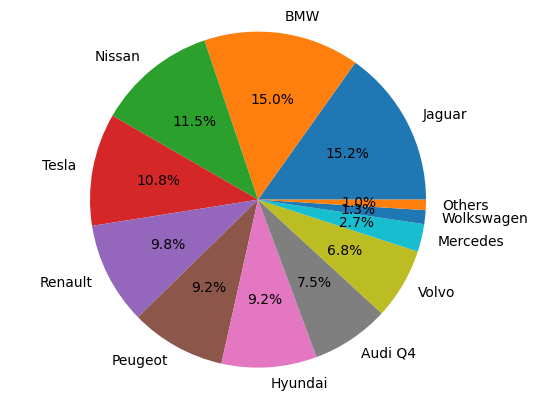

In [168]:
# Plot the population brand in a pie chart

# Values of each group
brand_values = aggregator.population_dataframe()['brand'].value_counts()
plt.pie(brand_values, labels=brand_values.index, autopct='%1.1f%%')

# View the plot
plt.axis('equal')
plt.show()

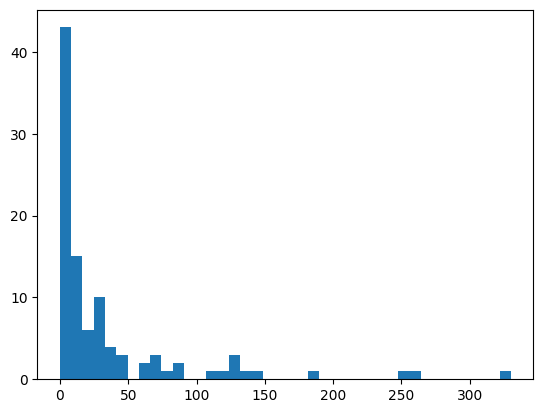

In [169]:
# Plot the trip distances in a histogram
plt.hist(aggregator.assigned_trips_dataframe()['trip_length'], bins=40)
plt.show()

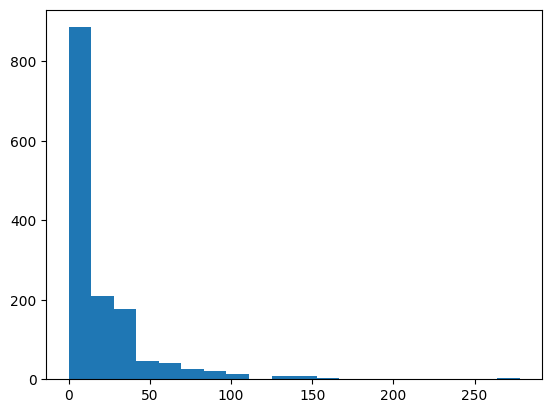

In [170]:
# Plot the segment distances in a histogram
plt.hist(aggregator.assigned_segments_dataframe()['trip_length'], bins=20)
plt.show()

In [171]:
aggregator.assigned_trips_dataframe()['trip_length'].mean()

34.2658

In [172]:
# EV charging history

aggregator.simulation_dataframes['gen001']['ev_charging_history']

,start_time,end_time,start_soc,end_soc,ev_id,station_type,station_power,duration,start_hour,end_hour
0,2023-01-01 17:30:25.706354,2023-01-01 18:13:52.109329,0.208496,0.740850,40c1aa631f02a35007af9287bf2d5e10,Public Fast (50 kW),50.0,0 days 00:43:26.402975,17,18
1,2023-01-01 19:10:00.000000,2023-01-01 23:31:53.081406,0.486501,0.768650,40c1aa631f02a35007af9287bf2d5e10,Residential Slow (7.2 kW),7.2,0 days 04:21:53.081406,19,23
2,2023-01-01 20:31:00.000000,2023-01-02 01:23:04.750000,0.291929,0.749193,3e042e191d18fdd7ba8ba558a23386f9,Residential Slow (7.2 kW),7.2,0 days 04:52:04.750000,20,1
3,2023-01-01 20:02:00.000000,2023-01-02 08:07:02.800000,0.289170,0.748917,26c0b631fe526929cddcf79b8db2beda,Residential Slow (3.6 kW),3.6,0 days 12:05:02.800000,20,8
4,2023-01-01 19:53:00.000000,2023-01-02 05:33:24.600000,0.592695,0.779269,8470e9bff713b3984b9e4d9ef441da6e,Residential Slow (3.6 kW),3.6,0 days 09:40:24.600000,19,5
...,...,...,...,...,...,...,...,...,...,...
63,2023-01-01 17:23:00.000000,2023-01-01 19:23:15.250000,0.728239,0.792824,3c5d8621d0b85be94aa3e42b090e38b9,Residential Slow (7.2 kW),7.2,0 days 02:00:15.250000,17,19
64,2023-01-01 18:49:00.000000,2023-01-01 22:36:08.100000,0.708801,0.790880,0d77c0562bdf506d703018f1ceb91a34,Residential Slow (3.6 kW),3.6,0 days 03:47:08.100000,18,22
65,2023-01-01 19:45:00.000000,2023-01-01 23:31:56.200000,0.709056,0.790906,d7661d5335b400051764a51f7bd82360,Residential Slow (3.6 kW),3.6,0 days 03:46:56.200000,19,23
66,2023-01-01 18:23:00.000000,2023-01-01 21:16:20.100000,0.789897,0.798990,519a90a2c3f75446c1a76aaaa362bc97,Residential Slow (3.6 kW),3.6,0 days 02:53:20.100000,18,21


In [173]:
# EV charging sessions per hour

aggregator.simulation_dataframes['gen001']['ev_charging_history_hourly']

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
40c1aa631f02a35007af9287bf2d5e10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
3e042e191d18fdd7ba8ba558a23386f9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26c0b631fe526929cddcf79b8db2beda,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8470e9bff713b3984b9e4d9ef441da6e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e07f5eff0d71bc0b35c0107cd4f606eb,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,0,0
d20bc497de8d68f75921b734898db8eb,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0
709e85f4de504beb61a3b57b17e0566b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,1,1,1,0
f7dd18e729fa5116ad49bfc2c832f1ea,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
77a862dd184c2a667bdc2462a28c3361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10f59e162c043f717ae3de9f0bfb6050,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0


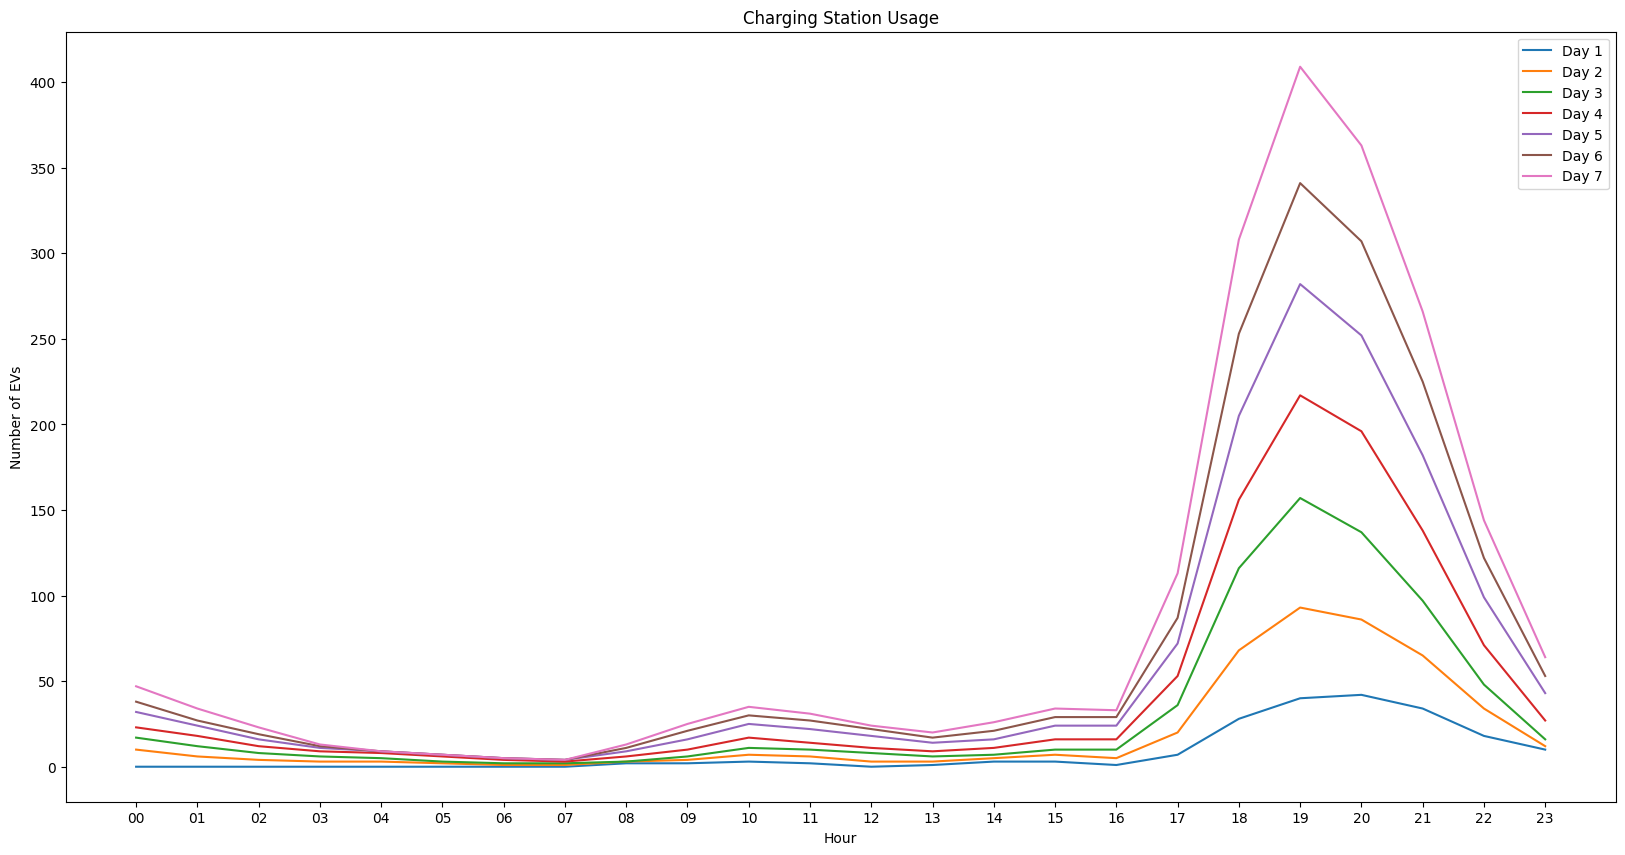

In [174]:
# Plot a timeline of the usage of the charging stations

# Pick a Day. If None, every day is plotted

DAY = None

# Create a figure
fig = plt.figure(figsize=(20, 10))

# Plot the data
if DAY is not None:
    plt.plot(np.sum(aggregator.simulation_dataframes['gen{:003d}'.format(DAY)]['ev_charging_history_hourly'], axis=0))
else:
    for i in range(1, len(aggregator.simulation_dataframes) + 1):
        plt.plot(np.sum(aggregator.simulation_dataframes['gen{:003d}'.format(i)]['ev_charging_history_hourly'], axis=0))

# Set the title
plt.title('Charging Station Usage')

# Set the x-axis label
plt.xlabel('Hour')

# Set the y-axis units
#plt.yticks(np.arange(0, max(np.sum(aggregator.simulation_dataframes['gen001']['ev_charging_history_hourly'], axis=0)), 5))

# Set the y-axis label
plt.ylabel('Number of EVs')

# Set the legend
if DAY is not None:
    plt.legend(['Day {}'.format(DAY)])
else:
    plt.legend(['Day {}'.format(i) for i in range(1, len(aggregator.simulation_dataframes) + 1)])

plt.show()

In [175]:
# EV charging sessions power per hour

aggregator.simulation_dataframes['gen001']['ev_charging_history_hourly_power']

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
40c1aa631f02a35007af9287bf2d5e10,0,0,0,0,0,0,0,0,0.00,0.00,...,0.00,0.00,0.0,25.00,10.83,6.00,7.20,7.20,7.20,3.72
3e042e191d18fdd7ba8ba558a23386f9,0,0,0,0,0,0,0,0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
26c0b631fe526929cddcf79b8db2beda,0,0,0,0,0,0,0,0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8470e9bff713b3984b9e4d9ef441da6e,0,0,0,0,0,0,0,0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
e07f5eff0d71bc0b35c0107cd4f606eb,0,0,0,0,0,0,0,0,0.00,0.00,...,8.43,16.50,0.0,0.00,0.00,0.00,4.03,20.53,0.00,0.00
d20bc497de8d68f75921b734898db8eb,0,0,0,0,0,0,0,0,0.00,0.00,...,0.00,2.93,20.9,0.00,0.00,0.00,15.03,9.53,0.00,0.00
709e85f4de504beb61a3b57b17e0566b,0,0,0,0,0,0,0,0,0.00,0.00,...,0.00,0.00,0.0,0.00,10.27,2.47,3.60,3.60,1.32,0.00
f7dd18e729fa5116ad49bfc2c832f1ea,0,0,0,0,0,0,0,0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.24,7.20,7.20,7.20,7.20,0.12
77a862dd184c2a667bdc2462a28c3361,0,0,0,0,0,0,0,0,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10f59e162c043f717ae3de9f0bfb6050,0,0,0,0,0,0,0,0,32.50,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,16.67,8.33,0.00,0.00


In [176]:
# Charging station usage type per hour

aggregator.simulation_dataframes['gen001']['ev_charging_history_hourly_type']

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
40c1aa631f02a35007af9287bf2d5e10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,Public Fast (50 kW),Public Fast (50 kW),Residential Slow (7.2 kW),Residential Slow (7.2 kW),Residential Slow (7.2 kW),Residential Slow (7.2 kW),Residential Slow (7.2 kW)
3e042e191d18fdd7ba8ba558a23386f9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26c0b631fe526929cddcf79b8db2beda,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8470e9bff713b3984b9e4d9ef441da6e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
e07f5eff0d71bc0b35c0107cd4f606eb,0,0,0,0,0,0,0,0,0,0,...,Private Semi-fast (22 kW),Private Semi-fast (22 kW),0,0,0,0,Private Semi-fast (22 kW),Private Semi-fast (22 kW),0,0
d20bc497de8d68f75921b734898db8eb,0,0,0,0,0,0,0,0,0,0,...,0,Private Semi-fast (22 kW),Private Semi-fast (22 kW),0,0,0,Private Semi-fast (22 kW),Private Semi-fast (22 kW),0,0
709e85f4de504beb61a3b57b17e0566b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Public Semi-fast (22 kW),Residential Slow (3.6 kW),Residential Slow (3.6 kW),Residential Slow (3.6 kW),Residential Slow (3.6 kW),0
f7dd18e729fa5116ad49bfc2c832f1ea,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Residential Slow (7.2 kW),Residential Slow (7.2 kW),Residential Slow (7.2 kW),Residential Slow (7.2 kW),Residential Slow (7.2 kW),Residential Slow (7.2 kW)
77a862dd184c2a667bdc2462a28c3361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10f59e162c043f717ae3de9f0bfb6050,0,0,0,0,0,0,0,0,Private Fast (50 kW),0,...,0,0,0,0,0,0,Private Fast (50 kW),Private Fast (50 kW),0,0


In [178]:
temp = [ev for ev in aggregator.simulation_variables['gen001']['assigned_evs'] if ev.ev_id == '10f59e162c043f717ae3de9f0bfb6050'][0]

temp.__dict__

{'brand': 'Jaguar',
 'model': 'I-Pace',
 'battery_type': 'BEV',
 'battery_size': 85,
 'charging_efficiency': 0.9,
 'discharging_efficiency': 0.9,
 'energy_per_km': 0.22,
 'soc_min': 0.7,
 'soc_max': 1.0,
 'probability_in_population': 0.09,
 'ev_id': '10f59e162c043f717ae3de9f0bfb6050',
 'soc': [0.86,
  0.7395032679738562,
  0.7939503267973856,
  0.6734535947712419,
  0.7873453594771243,
  0.6668486274509805,
  0.7866848627450981],
 'current_soc': 0.7866848627450981,
 'stopping_soc': 0.22258641985036304,
 'trips': [Trip length: 41.9 km, trip start time: 2023-01-01 07:05:00, trip end time: 2023-01-01 08:21:00, trip energy consumption: 9.218 kWh, trip required SOC: 0.10844705882352941 %,
  Trip length: 41.9 km, trip start time: 2023-01-01 12:04:00, trip end time: 2023-01-01 13:19:00, trip energy consumption: 9.218 kWh, trip required SOC: 0.10844705882352941 %,
  Trip length: 41.9 km, trip start time: 2023-01-01 19:26:00, trip end time: 2023-01-01 20:40:00, trip energy consumption: 9.218 kW

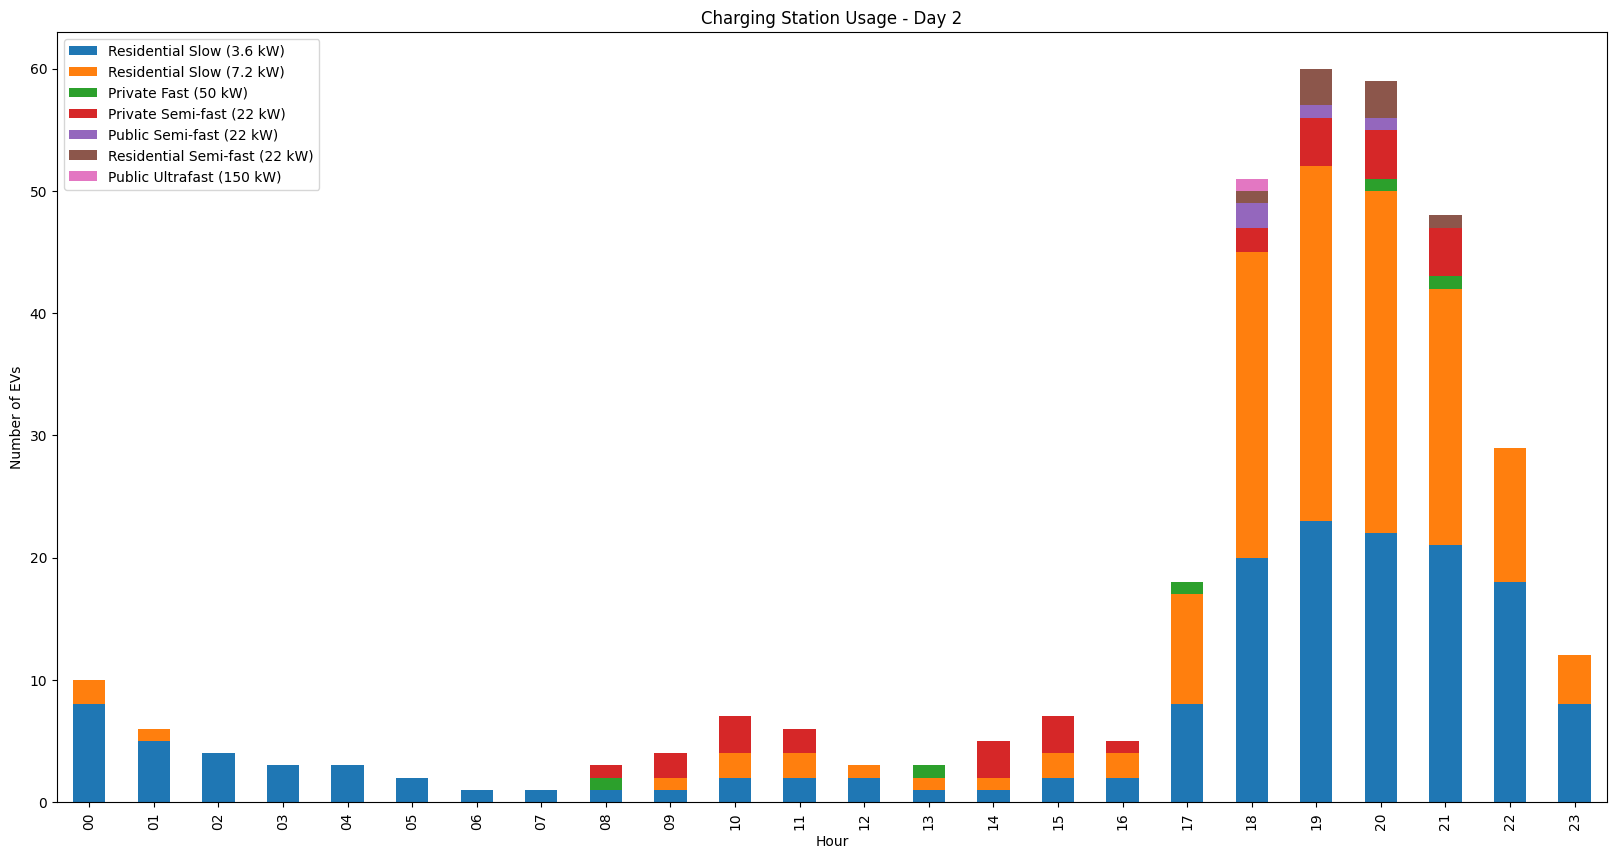

In [188]:
# Plot a stacked bar chart of the ev_charging_history_type_hourly DataFrame

DAY = 2

# Get the value counts of each charging type at each hour
ev_charging_history_type_hourly_value_counts = aggregator.simulation_dataframes['gen{:003d}'.format(DAY)]['ev_charging_history_hourly_type'].apply(pd.value_counts, axis=0)
ev_charging_history_type_hourly_value_counts.drop(0, inplace=True)
ev_charging_history_type_hourly_value_counts = ev_charging_history_type_hourly_value_counts.fillna(0)

# Plot the data
ev_charging_history_type_hourly_value_counts.transpose().plot(kind='bar', stacked=True, figsize=(20, 10))

# Set the title
plt.title('Charging Station Usage - Day {}'.format(DAY))

# Set the x-axis label
plt.xlabel('Hour')

# Set the y-axis label
plt.ylabel('Number of EVs')

plt.show()

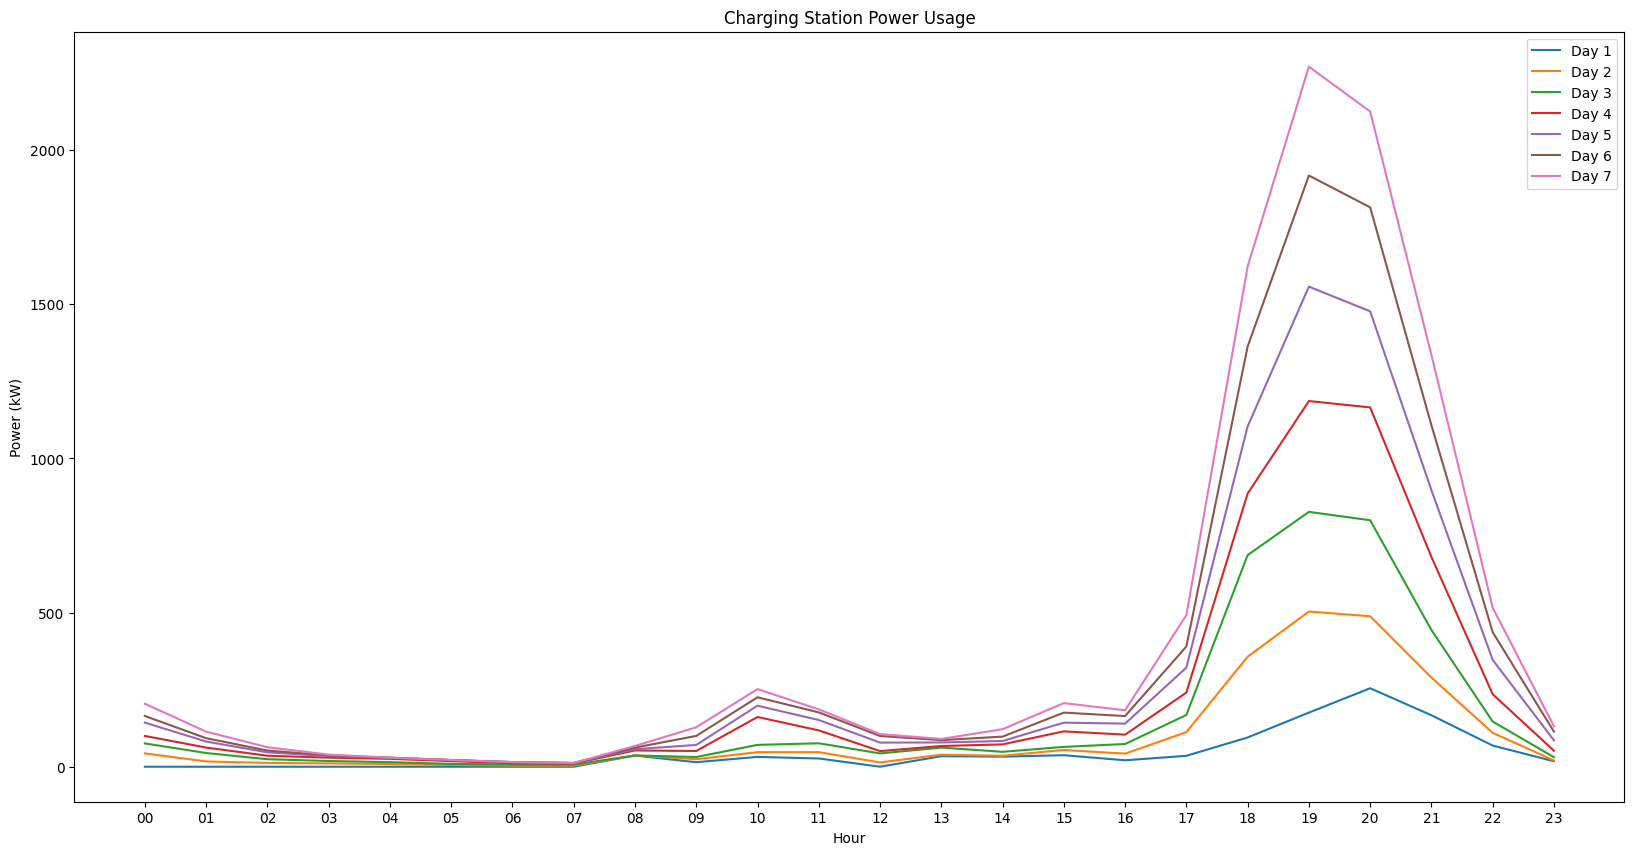

In [181]:
# Plot the sum of the power of the charging sessions at each hour

# Pick a Day. If None, every day is plotted
DAY = None

# Create a figure
fig = plt.figure(figsize=(20, 10))

# Plot the data
if DAY is not None:
    plt.plot(np.sum(aggregator.simulation_dataframes['gen{:003d}'.format(DAY)]['ev_charging_history_hourly_power'], axis=0))
else:
    for i in range(1, len(aggregator.simulation_dataframes) + 1):
        plt.plot(np.sum(aggregator.simulation_dataframes['gen{:003d}'.format(i)]['ev_charging_history_hourly_power'], axis=0))

# Set the title
plt.title('Charging Station Power Usage')

# Set the x-axis label
plt.xlabel('Hour')

# Set the labels
if DAY is not None:
    plt.legend(['Day {}'.format(DAY)])
else:
    plt.legend(['Day {}'.format(i) for i in range(1, len(aggregator.simulation_dataframes) + 1)])

# Set the y-axis label
plt.ylabel('Power (kW)')

plt.show()


In [182]:
# DataFrame of the energy required per EV by day

ev_charging_history_energy = pd.DataFrame(np.sum(aggregator.simulation_dataframes['gen001']['ev_charging_history_hourly_power'], axis=1), columns=['day_1'],
                                          index=aggregator.simulation_dataframes['gen001']['ev_charging_history_hourly_type'].index)

# Check if there are more than one day
if len(aggregator.simulation_dataframes) > 1:
    # Loop through the days
    for i in range(2, len(aggregator.simulation_dataframes) + 1):
        # Add the energy required per EV by day to the DataFrame, matching the EV IDs
        ev_charging_history_energy = ev_charging_history_energy.join(pd.DataFrame(np.sum(aggregator.simulation_dataframes['gen{:003d}'.format(i)]['ev_charging_history_hourly_power'], axis=1), columns=['day_{}'.format(i)],
                                                                                  index=aggregator.simulation_dataframes['gen{:003d}'.format(i)]['ev_charging_history_hourly_type'].index))

# Fill the NaN values with 0
ev_charging_history_energy = ev_charging_history_energy.fillna(0)

ev_charging_history_energy

,day_1,day_2,day_3,day_4,day_5,day_6,day_7
40c1aa631f02a35007af9287bf2d5e10,67.15,81.31,108.91,180.07,232.99,305.11,318.43
3e042e191d18fdd7ba8ba558a23386f9,0.00,23.16,33.36,33.36,33.36,33.36,33.36
26c0b631fe526929cddcf79b8db2beda,0.00,29.22,56.16,142.68,175.44,192.00,192.00
8470e9bff713b3984b9e4d9ef441da6e,0.00,38.88,38.88,38.88,38.88,38.88,49.02
e07f5eff0d71bc0b35c0107cd4f606eb,75.52,95.32,131.62,149.59,149.59,167.55,184.42
d20bc497de8d68f75921b734898db8eb,65.99,82.49,82.49,155.47,175.63,196.90,217.07
709e85f4de504beb61a3b57b17e0566b,21.26,25.70,25.70,25.70,25.70,25.70,31.34
f7dd18e729fa5116ad49bfc2c832f1ea,29.16,43.68,59.52,83.52,96.00,96.00,121.08
77a862dd184c2a667bdc2462a28c3361,0.00,15.78,15.78,15.78,28.26,28.26,28.26
10f59e162c043f717ae3de9f0bfb6050,91.67,133.34,181.67,208.33,262.50,313.34,426.67


In [183]:
# DataFrame with the EV IDs as index and a columns for the energy required per day, profile name and trip type

# Create a DataFrame with the EV IDs as index and a column for the energy required

ev_charging_history_energy = pd.DataFrame(np.sum(aggregator.simulation_dataframes['gen001']['ev_charging_history_hourly_power'], axis=1),
                                          columns=['day_1'],
                                          index=aggregator.simulation_dataframes['gen001']['ev_charging_history_hourly_type'].index)

# Check if there are more than one day
if len(aggregator.simulation_dataframes) > 1:
    # Loop through the days
    for i in range(2, len(aggregator.simulation_dataframes) + 1):
        # Add the energy required per EV by day to the DataFrame, matching the EV IDs
        ev_charging_history_energy = ev_charging_history_energy.join(pd.DataFrame(np.sum(aggregator.simulation_dataframes['gen{:003d}'.format(i)]['ev_charging_history_hourly_power'], axis=1), columns=['day_{}'.format(i)],
                                                                                  index=aggregator.simulation_dataframes['gen{:003d}'.format(i)]['ev_charging_history_hourly_type'].index))

# Fill the NaN values with 0
ev_charging_history_energy = ev_charging_history_energy.fillna(0)

# Get the assigned profiles
temp = aggregator.assigned_segments_dataframe()

ev_charging_history_energy['profile_name'] = 0
ev_charging_history_energy['trip_type'] = 0

# Iterate through the EVs
for ev_id in ev_charging_history_energy.index:
    # Get the EV profile type
    ev_profile = temp.loc[temp['ev_id'] == ev_id]['profile'].values[0]

    # Add the profile type to the DataFrame
    ev_charging_history_energy.loc[ev_id, 'profile_name'] = ev_profile.profile_name
    ev_charging_history_energy.loc[ev_id, 'trip_type'] = ev_profile.trip_type

ev_charging_history_energy

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,profile_name,trip_type
40c1aa631f02a35007af9287bf2d5e10,67.15,81.31,108.91,180.07,232.99,305.11,318.43,Residential4,Long
3e042e191d18fdd7ba8ba558a23386f9,0.00,23.16,33.36,33.36,33.36,33.36,33.36,Residential4,Long
26c0b631fe526929cddcf79b8db2beda,0.00,29.22,56.16,142.68,175.44,192.00,192.00,Residential4,Long
8470e9bff713b3984b9e4d9ef441da6e,0.00,38.88,38.88,38.88,38.88,38.88,49.02,Residential4,Long
e07f5eff0d71bc0b35c0107cd4f606eb,75.52,95.32,131.62,149.59,149.59,167.55,184.42,Work1,Long
d20bc497de8d68f75921b734898db8eb,65.99,82.49,82.49,155.47,175.63,196.90,217.07,Work1,Long
709e85f4de504beb61a3b57b17e0566b,21.26,25.70,25.70,25.70,25.70,25.70,31.34,Residential2,Medium
f7dd18e729fa5116ad49bfc2c832f1ea,29.16,43.68,59.52,83.52,96.00,96.00,121.08,Residential2,Medium
77a862dd184c2a667bdc2462a28c3361,0.00,15.78,15.78,15.78,28.26,28.26,28.26,Residential2,Medium
10f59e162c043f717ae3de9f0bfb6050,91.67,133.34,181.67,208.33,262.50,313.34,426.67,Work1,Long


C:\Users\camar\AppData\Local\Temp\ipykernel_15464\2374705735.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = ev_charging_history_energy.groupby('profile_name').sum()
C:\Users\camar\AppData\Local\Temp\ipykernel_15464\2374705735.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
C:\Users\camar\AppData\Local\Temp\ipykernel_15464\2374705735.py:38: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = ev_charging_history_energy.groupby('trip_type').sum()


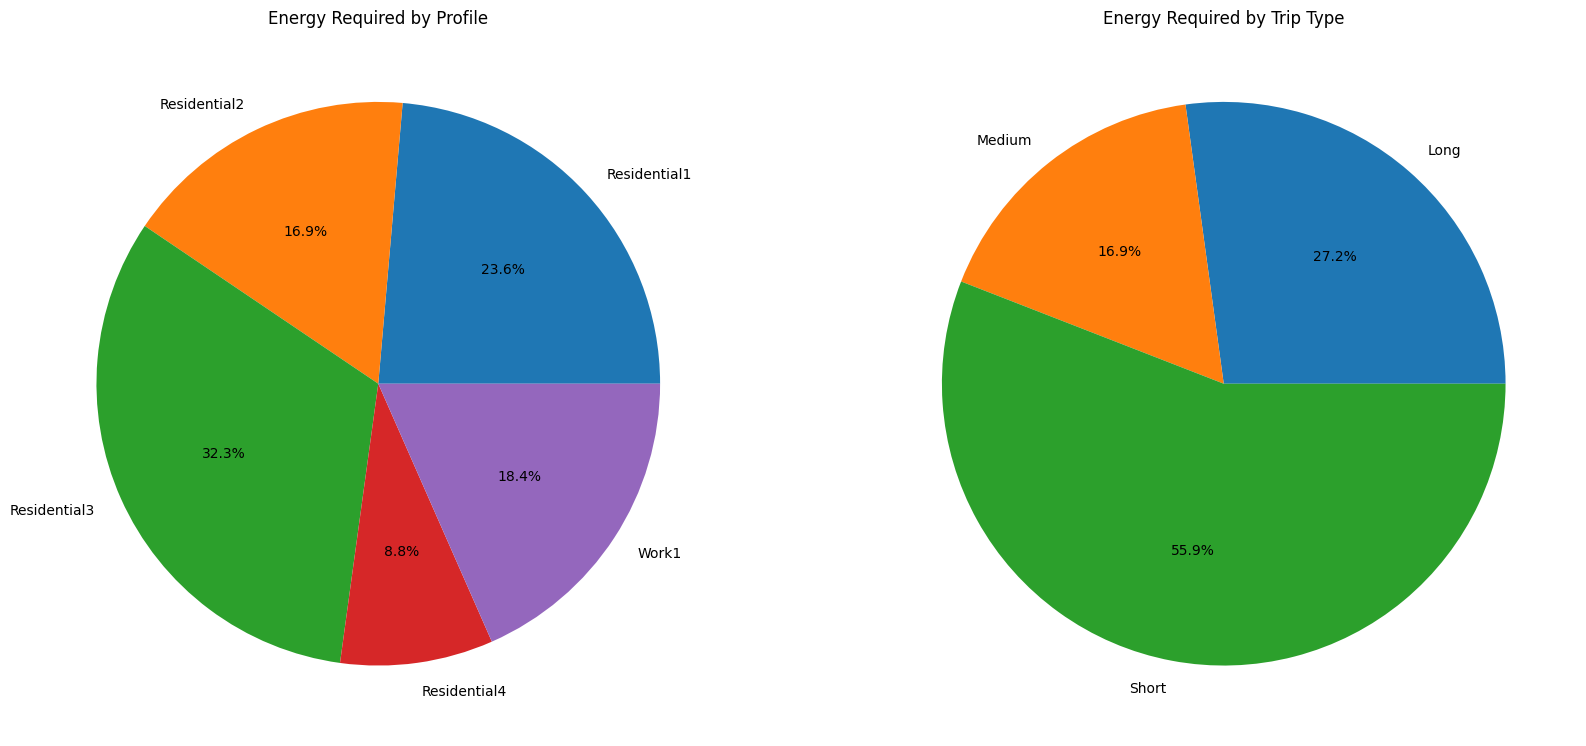

In [184]:
# Plot the energy required by the different profiles in a pie chart and the energy required by the different trip types in a pie chart

# Pick a Day. If None, sum of every day is plotted
DAY = None

# Create a figure
fig = plt.figure(figsize=(20, 10))

# Plot the data
if DAY is not None:
    # Set the title
    plt.title('Energy Required by Profile and Trip Type on Day {}'.format(DAY))

    # Plot the energy required by the different profiles in a pie chart
    plt.subplot(1, 2, 1)
    plt.pie(ev_charging_history_energy.groupby('profile_name')['day_{}'.format(DAY)].sum(), labels=ev_charging_history_energy.groupby('profile_name')['day_{}'.format(DAY)].sum().index, autopct='%1.1f%%')
    plt.title('Energy Required by Profile')

    # Plot the energy required by the different trip types in a pie chart
    plt.subplot(1, 2, 2)
    plt.pie(ev_charging_history_energy.groupby('trip_type')['day_{}'.format(DAY)].sum(), labels=ev_charging_history_energy.groupby('trip_type')['day_{}'.format(DAY)].sum().index, autopct='%1.1f%%')
    plt.title('Energy Required by Trip Type')
else:
    # Set the title
    plt.title('Energy Required by Profile and Trip Type')

    # Get the energy required by the different profiles across all days
    # Create a DataFrame with the energy required by the different profiles across all days
    temp = ev_charging_history_energy.groupby('profile_name').sum()

    # Plot the energy required by the different profiles in a pie chart
    plt.subplot(1, 2, 1)
    plt.pie(temp.sum(axis=1), labels=temp.sum(axis=1).index, autopct='%1.1f%%')
    plt.title('Energy Required by Profile')

    # Get the energy required by the different trip types across all days
    # Create a DataFrame with the energy required by the different trip types across all days
    temp = ev_charging_history_energy.groupby('trip_type').sum()

    # Plot the energy required by the different trip types in a pie chart
    plt.subplot(1, 2, 2)
    plt.pie(temp.sum(axis=1), labels=temp.sum(axis=1).index, autopct='%1.1f%%')
    plt.title('Energy Required by Trip Type')

plt.show()
